# Прогнозирование заработной платы по описанию вакансии

## Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

In [3]:
import nltk

In [39]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

In [61]:
from IPython.display import HTML, display_html

## Импорт исходных данных

In [4]:
data = pd.read_csv("vacancy_description.csv", index_col=None)

In [5]:
data

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
...,...,...,...,...,...,...,...,...,...,...,...,...
244763,72705211,TEACHER OF SCIENCE,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244764,72705212,TEACHER OF BUSINESS STUDIES AND ICT,Position: Qualified Teacher or NQT Subject/Spe...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244765,72705213,ENGLISH TEACHER,Position: Qualified Teacher Subject/Specialism...,Swindon,Swindon,NaN,contract,NaN,Teaching Jobs,450 - 500 per week,22800,hays.co.uk
244766,72705216,SUPPLY TEACHERS,Position: Qualified Teacher Subject/Specialism...,Wiltshire,Wiltshire,NaN,contract,NaN,Teaching Jobs,450 to 500 per week,22800,hays.co.uk


## Выделение целевой переменной

Одна из проблем с прогнозированием заработной платы заключается в том, что она странным образом распределяется: 
есть много людей, получающих стандартную зарплату, и несколько человек, которые получают кучу денег. 

Распределение имеет «толстый хвост» с правой стороны, что неудобно для минимизации MSE.

Есть несколько методов борьбы с этим: использование другой функции потерь, прогнозирование логарифмической цели вместо необработанной цели или даже замена целей их процентилями среди всех зарплат в обучающем наборе. Сейчас мы будем использовать логарифм.

_Подробнее можно прочитать [в официальном описании](https://www.kaggle.com/c/job-salary-prediction#description)._

In [6]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

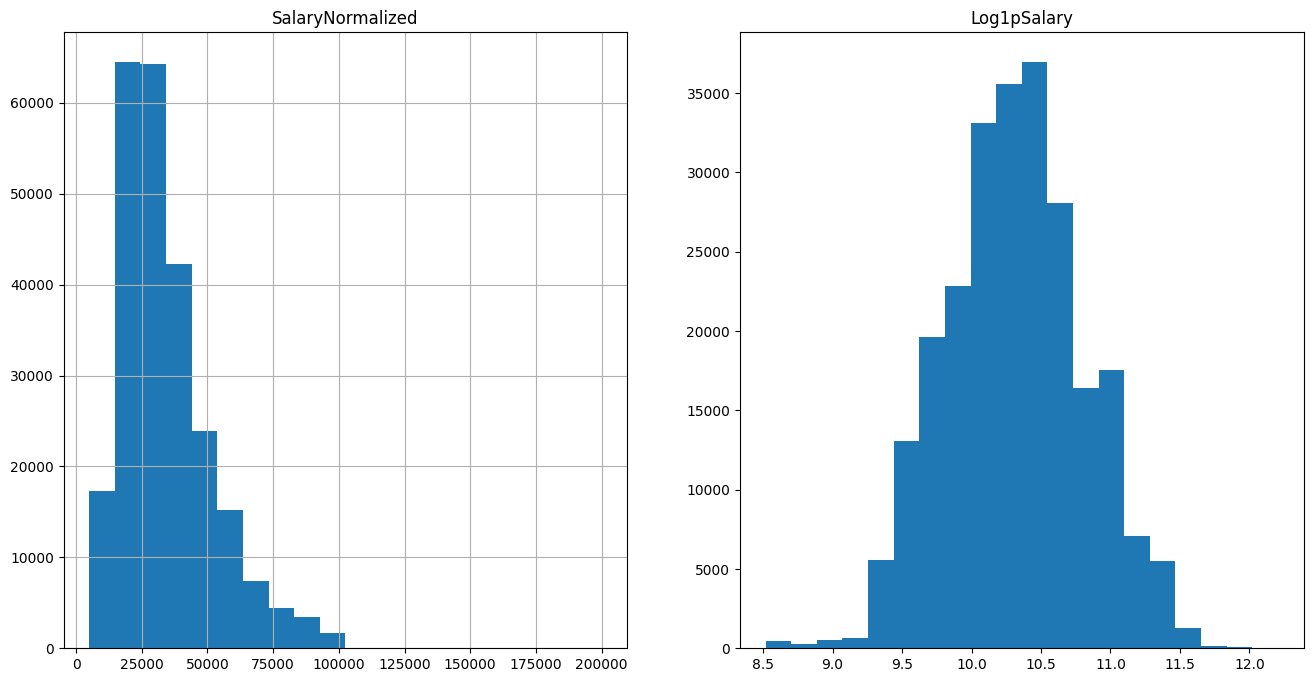

In [7]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20)
plt.grid(True)
plt.title('SalaryNormalized')

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20)
plt.title('Log1pSalary')

plt.show()

## Выделение признаков

Наша задача — предсказать одно число, `Log1pSalary`.

Для этого наша модель может получить доступ к ряду признаков:
* Произвольный текст: `Title` и `FullDescription`.
* Категориальные: `Category`, `Company`, `LocationNormalized`, `ContractType` и `ContractTime`.

In [8]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"

In [9]:
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(4)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
14649,66743464,Process Engineer,The Role Provide engineering support to the m...,Hartlepool,Hartlepool,full_time,NaN,MTrec Recruitment,Engineering Jobs,"33,000.00 - 37,000.00 per year",35000,Jobcentre Plus,10.463132
89059,69146204,Business Intelligence Developer Team Lead,Accenture is currently initiating various prog...,London,London,full_time,NaN,Accenture,IT Jobs,"40,005.00 - 45,000.00 per year",42502,Jobcentre Plus,10.657330
146193,70730208,Technical Consultant,"Word search: Security Consultant, Technical Co...",Nottingham East Midlands,Nottingham,NaN,permanent,NaN,IT Jobs,41000,41000,technojobs.co.uk,10.621352
137610,70414176,Mechanical Engineer (Cookstown),Our Client has around **** staff based near Du...,"Northern Ireland, Co. Tyrone, Dungannon",UK,full_time,permanent,Cranmore Recruitment,Manufacturing Jobs,"25,000 - 35,000",30000,nijobfinder.co.uk,10.308986


## Предварительная обработка текстовых данных

Как и на прошлой неделе, применение NLP к проблеме начинается с токенизации: разделения необработанного текста на последовательности токенов (слов, знаков препинания и т. д.).

Ваша задача — перевести в нижний регистр и маркировать все тексты в столбцах `Title` и `FullDescription`. Сохраняйте токенизированные данные в виде строки токенов, разделенных пробелами, из соображений производительности.

Можно использовать токенизаторы nltk. Утверждения были разработаны для WordPunctTokenizer, небольшие отклонения допустимы.

In [10]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

data["FullDescription"] = data["FullDescription"].astype(str).apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())), 1)
data["Title"] = data["Title"].astype(str).apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())), 1)

C:\Users\parkh\AppData\Local\Temp\ipykernel_17228\4091780559.py:3: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  data["FullDescription"] = data["FullDescription"].astype(str).apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())), 1)
C:\Users\parkh\AppData\Local\Temp\ipykernel_17228\4091780559.py:4: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  data["Title"] = data["Title"].astype(str).apply(lambda x: ' '.join(tokenizer.tokenize(x.lower())), 1)


In [11]:
data.head(4)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
0,12612628,engineering systems analyst,engineering systems analyst dorking surrey sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk,10.126671
1,12612830,stress engineer glasgow,stress engineer glasgow salary **** to **** we...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk,10.308986
2,12612844,modelling and simulation analyst,mathematical modeller / simulation analyst / o...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk,10.308986
3,12613049,engineering systems analyst / mathematical mod...,engineering systems analyst / mathematical mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk,10.221977



Не все слова одинаково полезны. Некоторые из них представляют собой опечатки или редкие слова, которые встречаются всего несколько раз. 

Давайте посчитаем, сколько раз каждое слово присутствует в данных, чтобы построить «белый список» известных слов.

Считаем, сколько раз каждый токен встречается как в `Title`, так и в `FullDescription`.
Создаем словарь {токен: его количество}

In [12]:
tokens = list()
for title in data["Title"]:
    tokens += title.split()
for title in data["FullDescription"]:
    tokens += title.split()
    
token_counts = Counter(tokens)

In [22]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)


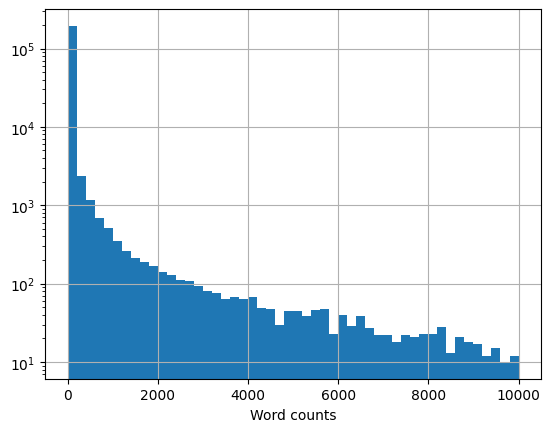

In [29]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts")
plt.grid(True)
plt.show()

Теперь отфильтруйте токены списка всех токенов, которые встречаются не менее 10 раз.

In [30]:
min_count = 10 # минимальная встречаемость

tokens = [token for token, count in token_counts.items() if count >= min_count]

Добавляем специальные токены для неизвестных и пустых слов

Потому что у пользователя при наборе текста могла зависнуть клава и выведется слово "кашшша", которое естесттвенно встретится 1 раз -> `UNK`

`PAD` нужен для обрамления текста

In [31]:
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + sorted(tokens)
print("Vocabulary size:", len(tokens))

Vocabulary size: 34158


Создайте обратный индекс токена: словарь от токена (строки) до его индекса в `tokens` (int)

In [32]:
token_to_id = {token: id for id, token in enumerate(tokens)}

In [33]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


Воспользуемся словарем, который создали, для преобразования текстовых строк в матрицы, усваиваемые нейронной сетью.

In [35]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """Преобразование списка токенов в матрицу с заполнением нехватки длины PAD"""
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

Пример работы функции as_matrix

In [37]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


## Кодировка категориальных признаков

Теперь давайте закодируем имеющиеся у нас категориальные данные.
Как обычно, для простоты мы будем использовать one-hot encoding. Престижно, если вы реализуете более продвинутые кодировки: tf-idf, pseudo-time-series и т. д.

In [47]:
top_companies, top_counts = zip(*Counter(data['Company']).items())
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

## DL

Здесь мы совершили небольшое преступление: мы использовали все данные для токенизации и создания словаря. Более строгим способом было бы выполнить эту часть только на тренировочном наборе. Возможно, вы захотите сделать это и измерить масштаб изменений.

In [48]:
data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [49]:
def make_batch(data, max_len=None, word_dropout=0):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

Визуализация работы функции make_batch

In [50]:
make_batch(data_train[:3], max_len=10)

{'Title': array([[27645, 29893, 33674,     1,     1,     1,     1],
        [29239,   197, 19175, 20042, 15554, 23162,  4051],
        [10609, 30412, 17746,    33,  8705, 29157,    65]]),
 'FullDescription': array([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451,
         32939],
        [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,
            82],
        [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412,
         17746]]),
 'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'Log1pSalary': array([ 9.71154 , 10.463132, 10.71444 ], dtype=float32)}

## Архитектура НС

Наша базовая модель состоит из трех ветвей:
* Кодировщик названий
* Кодировщик описания
* Кодировщик категориальных функций

Затем мы объединим все три ветви в одну общую сеть, которая прогнозирует зарплату.

<img src="https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png" width=600px>

Это явно не вписывается в интерфейс Sequential keras. 

Чтобы построить такую сеть, нужно будет использовать [Keras Functional API](https://keras.io/models/model/).

In [51]:
import keras
import keras.layers as L

In [52]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
    """ Build a model that maps three data sources to a single linear output: predicted log1p(salary) """
    
    l_title = L.Input(shape=[None], name="Title")
    l_descr = L.Input(shape=[None], name="FullDescription")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    # Build your monster!
    
    emb = L.Embedding(n_tokens, 2 * hid_size) # эмбединг
    
    l_title_emb = emb(l_title)
    l_descr_emb = emb(l_descr)
    
    l_title_conv = L.Convolution1D(hid_size, kernel_size=2, activation='relu')(l_title_emb)
    l_descr_conv = L.Convolution1D(hid_size, kernel_size=5, activation='relu')(l_descr_emb)
    
    l_title_out = L.GlobalMaxPool1D()(l_title_conv)
    l_descr_out = L.GlobalMaxPool1D()(l_descr_conv)
    
    l_categ_out = L.Dense(hid_size, activation='relu')(l_categ)
    
    l_combined = L.Concatenate()([l_title_out, l_descr_out, l_categ_out])
    
    l_dense_clf = L.Dense(hid_size, activation='relu')(l_combined)
    
    output_layer = L.Dense(1)(l_dense_clf)
    # end of your code
    
    model = keras.models.Model(inputs=[l_title, l_descr, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['mean_absolute_error'])
    return model
    

In [53]:
model = build_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Title (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FullDescription     │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  4,372,224 │ Title[0][0],      │
│ (Embedding)         │                   │            │ FullDescription[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, None, 64)  │     16,448 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, None, 64)  │     41,024 │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Categorical         │ (None, 3768)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d[0][0]      │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ conv1d_1[0][0]    │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    241,216 │ Categorical[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 192)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     12,352 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,683,329 (17.87 MB)

 Trainable params: 4,683,329 (17.87 MB)

 Non-trainable params: 0 (0.00 B)

Проверка работоспособности

In [54]:
dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), data_train['Log1pSalary'][:100])[0]
assert dummy_pred.shape == (100, 1)
assert len(np.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert np.ndim(dummy_loss) == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


## Обучение и оценка

Как обычно, мы будем кормить нашего монстра случайными мини-пакетами данных. 

Во время обучения мы хотим отслеживать не только функцию потерь, которая вычисляется в логарифмическом-пространстве, но и фактическую ошибку, измеряемую в долларах.

In [55]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

## Обучение модели

Теперь мы можем подогнать нашу модель обычным мини-пакетным способом. Интересно то, что мы обучаемся на бесконечном потоке мини-пакетов, создаваемых функцией iterate_minibatches.

In [56]:
batch_size = 256
epochs = 10  # definitely too small!
steps_per_epoch = 100  # for full pass over data: (len(data_train) - 1) // batch_size + 1

In [58]:
model = build_model()
model.fit(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 398ms/step - loss: 29.5804 - mean_absolute_error: 3.9262 - val_loss: 0.3433 - val_mean_absolute_error: 0.4157
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 398ms/step - loss: 0.2796 - mean_absolute_error: 0.3801 - val_loss: 0.2270 - val_mean_absolute_error: 0.3323
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 400ms/step - loss: 0.1960 - mean_absolute_error: 0.3155 - val_loss: 0.2065 - val_mean_absolute_error: 0.3269
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 397ms/step - loss: 0.1539 - mean_absolute_error: 0.2777 - val_loss: 0.1612 - val_mean_absolute_error: 0.2873
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - loss: 0.1339 - mean_absolute_error: 0.2616 - val_loss: 0.1231 - val_mean_absolute_error: 0.2515
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - loss: 0.1211 - mean_absolute_error: 0.2530 - val_loss: 0.1219 - val_mean_absolute_error: 0.2557
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 405ms/step - loss: 0.1061 - mean_abso

In [59]:
def print_metrics(model, data, batch_size=batch_size, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    for batch_x, batch_y in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
        batch_pred = model.predict(batch_x)[:, 0]
        squared_error += np.sum(np.square(batch_pred - batch_y))
        abs_error += np.sum(np.abs(batch_pred - batch_y))
        num_samples += len(batch_y)
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % (squared_error / num_samples))
    print("Mean absolute error: %.5f" % (abs_error / num_samples))
    return squared_error, abs_error
    
print_metrics(model, data_train, name='Train')
print_metrics(model, data_val, name='Val')

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
8/8 ━━━━━━━━━━━━━━━━━━

(3171.400375366211, 9263.291315078735)

## Бонусная часть: объяснение прогнозов модели

Обычно полезно понять, как работает ваша модель, прежде чем позволить ей принимать реальные решения. 
Для линейных моделей все просто: просто посмотрите, какие слова получили положительный или отрицательный вес. 
Однако гораздо сложнее это сделать для нейронных сетей, которые изучают сложные нелинейные зависимости.

Однако есть несколько способов заглянуть внутрь черного ящика:
* Наблюдение за тем, как модель реагирует на входные возмущения.
* Поиск входных данных, которые максимизируют/минимизируют активацию некоторых выбранных нейронов (_подробнее [на distill.pub](https://distill.pub/2018/building-blocks/)_)
* Создание локальных линейных аппроксимаций вашей нейронной сети: [статья](https://arxiv.org/abs/1602.04938), [библиотека eli5](https://github.com/TeamHG-Memex/eli5/tree/master/ eli5/форматеры)

Сегодня мы попробуем первый метод, потому что он самый простой.

Т.е. как удаление одного из слов влияет на предсказание ЗП вакансии

In [60]:
def explain(model, sample, col_name='Title'):
    """Computes the effect each word had on model predictions"""
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens)) 

    *predictions_drop_one_token, baseline_pred = model.predict(make_batch(data_drop_one_token))[:, 0]
    diffs = baseline_pred - predictions_drop_one_token
    return list(zip(sample_col_tokens, diffs))

In [62]:
def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html

In [63]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


sales specialist iv access and infusion

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [64]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


cleaning operative

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [65]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model.predict(make_batch(data.iloc[i: i+1]))[0, 0]))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 26812
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Salary (gbp): 2814.3906
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


designate store manager

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


we ’ re making history . what part will you play ? you may not be aware that game has recently been bought and a very exciting future lies ahead . we are investing in our key stores and bringing the best talent into the organisation to build the number one specialist video games retailer in the uk . we are currently recruiting for a designate store manager for our fantastic game stores in suffolk . it ' s an exciting place to work with great locations , with the potential to deliver fantastic results and to progress your career further . we are looking for a dynamic , inspirational store manager to play a key role in delivering even better results whilst maintaining a welcoming , efficient and safe environment for our customers and staff alike . about you we are looking for store managers , ideally with a passion for gaming , who are able to demonstrate the following : proven track record of success in a management position within retail or a similar environment experience in managing p l experience in leading a team within a salesfocused and high turnover environment excellent interpersonal skills ability to coach and develop your staff members to success ability to make our customer ' s experience a truly exceptional one so they return time and time again ability to work on own initiative and able to cope with changing priorities self motivation and the ability to inspire change within your team the wider business confidence and professionalism team player attitude excellent time management skills and able to meet deadlines calm and resilient work ethic with the ability to work well under pressure in return we will pay you a great salary , offer fantastic opportunities for development and promotion and an exciting place to work . please note : due to the number of applications we receive , we are not able to respond to each application individually . if you have not heard from us with 2 weeks , then please assume that your application has been unsuccessful at this time , but do not be deterred from showing your interest in future vacancies that arise . this job was originally posted as www . retailchoice . com / jobseeking / UNK ****

Ужасная идея для стартапа №1962: создать инструмент, который автоматически перефразирует вашу должностную инструкцию (или резюме) в соответствии с ожиданиями по зарплате :)